# Handwritten digits

Sometimes you might want to apply multiple ML techniques. For example, just because you have labels in your training data doesn't mean that a regression algorithm will work very well. So, you might want to start with a clustering or dimensional reduction algorithm first.

Here we're going to use the [MNIST database](https://en.wikipedia.org/wiki/MNIST_database). This contains a set of images with handwritten digts. It is one of the most widely used and best studied datasets in the whole of machine learning. It's part of the standard tests new tecniques need to face.

Let's load the dataset first.

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.manifold import Isomap
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [89]:
digits = datasets.load_digits()
print(digits.images.shape)
print(digits.keys())

(1797, 8, 8)
dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


In [90]:
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 1797
:Number of Attributes: 64
:Attribute Information: 8x8 image of integer pixels in the range 0..16.
:Missing Attribute Values: None
:Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
:Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an in

Here are a few of the images in the dataset:

![Test](Test.png)

## Part 0

**Tasks**

1. First thing, grab a piece of paper and visually classify those 25 digits. We'll see if you're better or worse than a computer!

Spoiler alert: Davide's efficiency was ~80%, much worse than ML!

2. Here is how you plot the images and the corresponding labels (The one thing I'm not telling you of course is the random seed I used to select those above). After you've seen this ones, go back to your piece of paper and update your choices if you want. Keep track of both set of preditions. This is like supervised learning.

Ok so the data is simply each pixel value within an 8 x 8 grid. For this analysis, we don't care about the 2-D nature of the image, we can just treat it as an 8 x 8 = 64 dimensional array. So our data have 1797 samples in 64 dimensions.

Then each of the 1797 images has a label.

In [91]:
my_guesses = [
    [8., 9., 8., 1., 2., 6., 9.],
    [1., 9., 4., 0., 6., 1., 7.],
    [6., 9., 5., 4., 4., 8., 4.],
    [0., 5., 6., 1., 7., 9., 3.],
    [2., 1., 0., 8., 3., 9., 6.],
    [1., 1., 2., 0., 5., 4., 4.],
    [9., 6., 2., 6., 1., 0., 0.]
]

The solutions are:

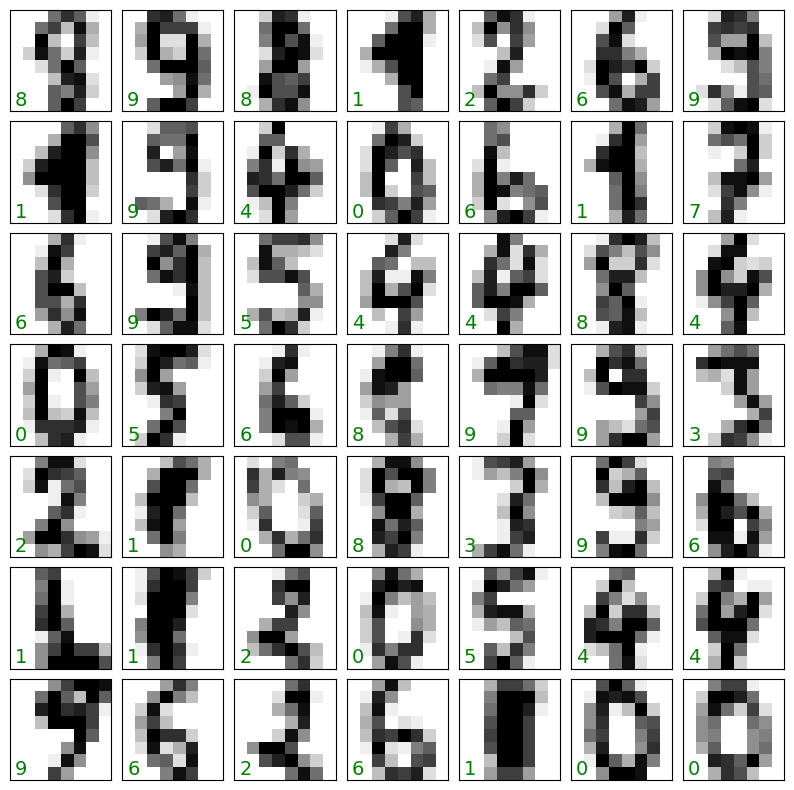

In [92]:
fig, axes = plt.subplots(7,7, figsize=(10, 10))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

np.random.seed(4321) #### This was the seed
mychoices = np.random.choice(digits.images.shape[0],49)
np.random.seed()

for i, ax in enumerate(axes.flat):
    ax.imshow((digits.images[mychoices[i]]), 
              cmap='binary')
    ax.text(0.05, 0.05, str(digits.target[mychoices[i]]),transform=ax.transAxes, color='green', fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])

In [93]:
# Accurancy
flat_guesses = np.array(my_guesses).flatten()
true_labels = digits.target[mychoices]

correct = np.sum(flat_guesses == true_labels)
accuracy = correct / len(true_labels)

print(f"Accuracy: {accuracy:.2%} ({correct} out of {len(true_labels)})")

Accuracy: 95.92% (47 out of 49)


My efficiency is higher than Davide's! Now let's see if I'm better than a computer.

## Part 1 - Unsupervised Learning: Dimensionality Reduction on Digits

**Tasks**

We'd like to visualize our points within the 64-dimensional parameter space, but it's difficult to plot points in $N = 64$ dimensions! So we need to reduce the dimensionality of the space

3. Use the unsupervised dimensionality reduction technique called Isomap. Isomap is an embedding tecnique, which tries to understand if your $N$ dimensional datapoint live in a $N$ dimensional (with $N < M$) manyfold. Reduce the MINST dataset. Do some plots to visualize your results

Note. Isomap is very recent. It was introduced by Tenenbaum et al (2000) ---a paper that has something like $1.5$ x $10^4$ citations.

In [94]:
# 2D Isomap on the entire dataset
embedding = Isomap(n_components=2)
digits_transformed = embedding.fit_transform(digits.data)
print(digits.data.shape, "-->", digits_transformed.shape)

/home/alessia_pozzi/.local/lib/python3.10/site-packages/sklearn/manifold/_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/alessia_pozzi/.local/lib/python3.10/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


(1797, 64) --> (1797, 2)


`Isomap` has turned our $1797 \times 64$ dimensional data set into a $1797 \times 2$ dimensional dataset. This is much easier to visualize, so let's see if this visualization is at all helpfull.

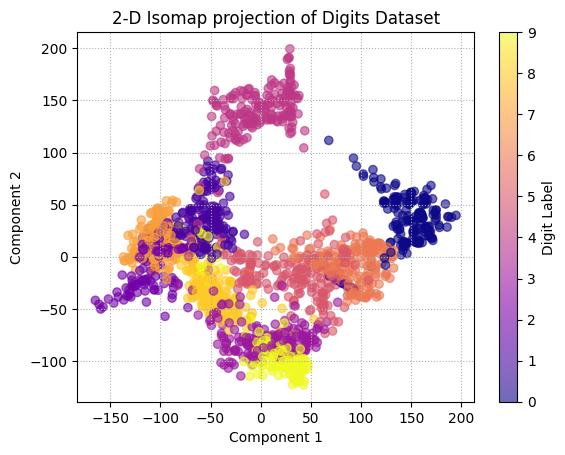

In [127]:
scatter = plt.scatter(digits_transformed[:, 0], digits_transformed[:, 1], c=digits.target, cmap='plasma', alpha=0.6)
plt.colorbar(scatter, label='Digit Label')
plt.title("2-D Isomap projection of Digits Dataset")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(linestyle=':')
plt.show()

We see here that the digits are fairly well-separated in the parameter space. This tells us that a supervised classification algorithm should perform fairly well.

## Part 2: Supervised Learning: Classification on Digits

**Tasks**

Now we want to classify the dataset.

4. Split the dataset taking 80% of the images as tranining dataset and leaving the other 20% as a validation set. You need sklearn.model_selection.train_test_split.

5. Use a simple Logistic Regression which despite its name is a common classification algorithm. (I know, this is confusing!). Use the flag solver='sag' (I found the default solver had a bug, at least when I tried).

6. Compute the accuracy (sklearn.metrics.accuracy_score) of your emulator. In this context, accuracy is simply the fraction of the digits that were correctly identified. Compute the accuracy on both the training and the validation set. Comment on the results.

7. The accuracy is a single number doesn't tell us where we've gone wrong. Plot the confusion matrix as we did above. What are the digits that are more challenging to identify, does it make sense?

There are many ways to improve this classifier, for example using a more sophisticated model, use cross validation, etc. We'll get to those in the coming weeks.

In [116]:
# Split the dataset in a training dataset (80%) and a test dataset (20%)
x_train, x_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.2)


print("Training set dimension: ", x_train.shape, y_train.shape)
print("Test set dimension: ", x_test.shape, y_test.shape)

Training set dimension:  (1437, 64) (1437,)
Test set dimension:  (360, 64) (360,)


In [117]:
# Logistic Regression
modelLR = LogisticRegression(solver='sag', max_iter = 1000) 
modelLR.fit(x_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'sag'
,max_iter,1000
,multi_class,'deprecated'


In [118]:
# Predictions
y_pred_train_LR = modelLR.predict(x_train)
y_pred_test_LR = modelLR.predict(x_test)

# Accuracy
acc_train = accuracy_score(y_train, y_pred_train_LR)
acc_test = accuracy_score(y_test, y_pred_test_LR)

print(f"Accuracy on training set:  {acc_train:.4f}")
print(f"Accuracy on validation set: {acc_test:.4f}")

Accuracy on training set:  1.0000
Accuracy on validation set: 0.9778


The Logic Regression has a 100% accuracy on the training set which means that it has correctly identify all trainig examples. The accuracy on the validation set is 97.78% which indicates that the model can be generalise well to unseen data.

Moreover, the computer accurancy is better the mine :(

In [119]:
# Confusion matrix
cm_train = confusion_matrix(y_train, y_pred_train_LR)
cm_test = confusion_matrix(y_test, y_pred_test_LR)

print("Confusion Matrix - Training Set")
print(cm_train)
print("\nConfusion Matrix - Test Set")
print(cm_test)

Confusion Matrix - Training Set
[[144   0   0   0   0   0   0   0   0   0]
 [  0 146   0   0   0   0   0   0   0   0]
 [  0   0 135   0   0   0   0   0   0   0]
 [  0   0   0 147   0   0   0   0   0   0]
 [  0   0   0   0 139   0   0   0   0   0]
 [  0   0   0   0   0 144   0   0   0   0]
 [  0   0   0   0   0   0 145   0   0   0]
 [  0   0   0   0   0   0   0 145   0   0]
 [  0   0   0   0   0   0   0   0 147   0]
 [  0   0   0   0   0   0   0   0   0 145]]

Confusion Matrix - Test Set
[[34  0  0  0  0  0  0  0  0  0]
 [ 0 35  1  0  0  0  0  0  0  0]
 [ 0  0 42  0  0  0  0  0  0  0]
 [ 0  0  1 35  0  0  0  0  0  0]
 [ 0  0  0  0 40  0  0  1  0  1]
 [ 0  0  0  1  1 35  0  1  0  0]
 [ 0  0  0  0  0  0 36  0  0  0]
 [ 0  0  0  0  0  0  0 34  0  0]
 [ 0  0  0  0  0  0  0  0 26  1]
 [ 0  0  0  0  0  0  0  0  0 35]]


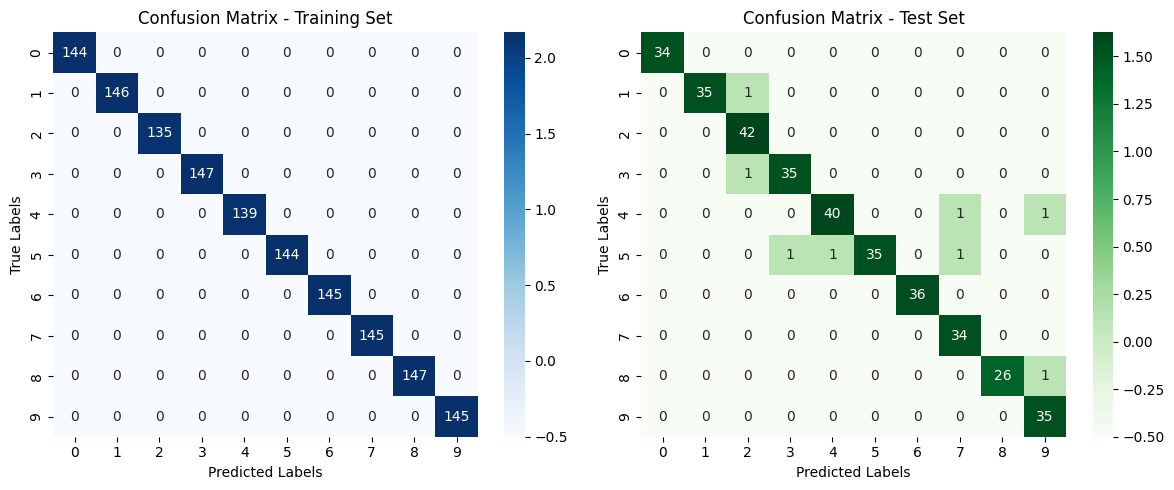

In [120]:
# Plot the Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
epsilon = 10**(-0.5)  # small constant

# Training set
log_train = np.log10(cm_train + epsilon) 
sns.heatmap(log_train, cmap='Blues', ax=axes[0], annot=cm_train, fmt='d')
axes[0].set_title('Confusion Matrix - Training Set')
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')

# Test set
sns.heatmap(np.log10(cm_test+epsilon), cmap='Greens', ax=axes[1], annot=cm_test, fmt='d')
axes[1].set_title('Confusion Matrix - Test Set')
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('True Labels')

plt.tight_layout()
plt.show()